<a href="https://colab.research.google.com/github/Sinchani/2048/blob/master/Overwiew_of_Multimodality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

 Books					 'Neo4j Courses'
'Colab Notebooks'			 'Notes on HOW POWERFUL ARE GRAPH NEURAL NETWORKS?.gjam'
'Coursera courses'			 'OpenAI free credits Info.gdoc'
 CV					  Others
'Getting started.pdf'			  Productivity
'GRE Prep'				  Report.gdoc
'How are you acting today? (Poem).gdoc'  'Research Tips & Tools'
'Hyperbolic basics.gdoc'		 'Shromona’s Marriage '
 Letter.gdoc				  Work


In [ ]:
!pip install -q accelerate torch

In [ ]:
!pip install -U scikit-learn
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.7 MB/s eta 0:00:00


In [ ]:
import warnings

In [ ]:
warnings.filterwarnings('ignore')

#Import Libraries

In [ ]:
#Import neural network training libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

#Import basic computation libraries along with data vizualization and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tqdm.notebook as tqdm
from tqdm import tqdm
from sklearn.decomposition import PCA
import umap

#Handling umap.plot error. Fix ---> !pip install datashader. The below immediate code segment might not be required. Not part of the Tutorial
#import datashader as ds
#import datashader.transfer_functions as tf
#import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
#import holoviews.operation.datashader as hd

import umap.plot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [ ]:
# Import our data class which will organize MNIST and provide anchor, positive and negative samples.
from mnist_dataset import MNISTDataset

# Load MNIST Dataset

In [ ]:
#Load data from csv
data = pd.read_csv('digit-recognizer/train.csv')
val_count = 1000
# common transformation for both val and train
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# split data into train and val
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

100%|██████████| 1000/1000 [00:01<00:00, 863.92it/s]


# Setup our DataLoaders

In [ ]:
# Create torch dataloaders
trainLoader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)
valLoader = DataLoader(val_dataset,
                       batch_size=256,
                       shuffle=True,
                       pin_memory=True,
                       num_workers=2,
                       prefetch_factor=100
)

# Visualize datapoints

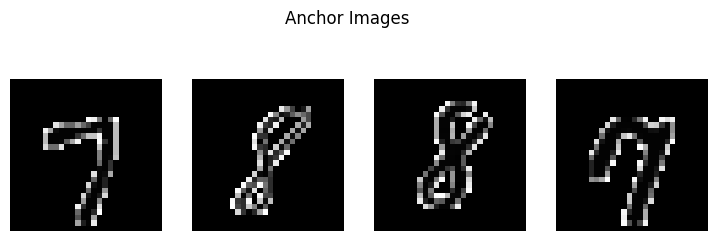

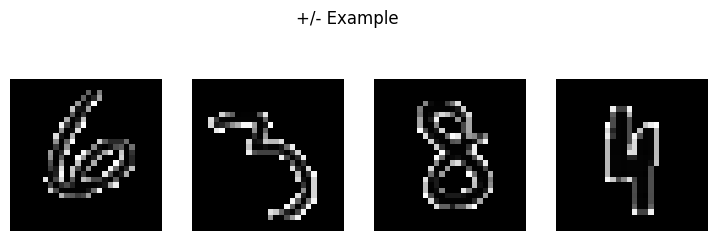

In [ ]:
# Functions to display images with labels
def show_images(images, title=''):
  num_images = len(images)
  fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
  for i in range(num_images):
    img = np.squeeze(images[i])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
  fig.suptitle(title)
  plt.show()

# Vizualize some examples
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
  anchor_images = anchor_images.numpy()
  contrastive_images = contrastive_images.numpy()
  labels = labels.numpy()

  # Display some samples from the batch
  show_images(anchor_images[:4], title='Anchor Images')
  show_images(contrastive_images[:4], title='+/- Example')

  # Break after displaying one batch for demonstration
  break

# Build Neural Network Architecture

In [ ]:
# Define a neural network architecture with two convolution layers and two fully connected layers
# Input to the network is an MNIST image and Output is a 64 dimensional representation.
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((2, 2), stride=2),
        nn.Dropout(0.3)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((2, 2), stride=2),
        nn.Dropout(0.3)
    )
    self.linear1 = nn.Sequential(
        nn.Linear(64 * 4 * 4, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, 64),
    )

  def forward(self, x):
    x = self.conv1(x) # x: d * 32 * 12 * 12
    x = self.conv2(x) # x: d * 64 * 4  * 4
    x = x.view(x.size()[0], -1) # x: d * (64*4*4)
    x = self.linear1(x) # x: d * 64
    return x


# Contrastive Loss Function

In [ ]:
# The ideal distance metric for a positive sample is set to 1, for a negative sample it is set to 0
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, anchor, contrastive, distance):
        # use cosine similarity from torch to get score
        score = self.similarity(anchor, contrastive)
        # after cosine apply MSE between distance and score
        return nn.MSELoss()(score, distance) #Ensures that the calculated score is close to the ideal distance (1 or 0)

Define the Training Configuration

In [ ]:
net = Network()

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')

net = net.to(device)
device

'cpu'

In [ ]:
# Define the training configuration
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

# Training Loop

In [ ]:
import os
# Define a directory to save checkpoints
checkpoint_dir = '/content/checkpoints'

#Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

Model Training

In [ ]:
def train_model(epoch_count=10):#
    net = Network()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])

        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

In [ ]:
def train_model(epoch_count=10):#
    net = Network()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])

        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

# Load from backup

In [ ]:
def load_model_from_checkpoint():
    checkpoint = torch.load('/content/checkpoints/model_epoch_8.pt')

    net = Network()
    net.load_state_dict(checkpoint)
    net.eval()

    return net

Set the `train` variable to `TRUE` if you'd like to train the model, otherwise you will load a trained checkpoint of the model.

# Get the Model

In [ ]:
train = True # set to True to run train the model

if train:
    training_result = train_model()
    model = training_result["net"]
else:
    model = load_model_from_checkpoint()

epoch - 0
learning rate 0.005


100%|██████████| 1265/1265 [01:05<00:00, 19.28it/s]


epoch_loss 0.26296985008028656
epoch - 1
learning rate 0.005


100%|██████████| 1265/1265 [01:08<00:00, 18.36it/s]


epoch_loss 0.26327261340476776
epoch - 2
learning rate 0.005


100%|██████████| 1265/1265 [01:09<00:00, 18.19it/s]


epoch_loss 0.2630140945374259
epoch - 3
learning rate 0.005


100%|██████████| 1265/1265 [01:08<00:00, 18.34it/s]


epoch_loss 0.2621109913460351
epoch - 4
learning rate 0.005


100%|██████████| 1265/1265 [01:06<00:00, 18.89it/s]


epoch_loss 0.2623096571609437
epoch - 5
learning rate 0.005


100%|██████████| 1265/1265 [01:05<00:00, 19.21it/s]


epoch_loss 0.26219496896615613
epoch - 6
learning rate 0.005


100%|██████████| 1265/1265 [01:05<00:00, 19.26it/s]


epoch_loss 0.2617975890872036
epoch - 7
learning rate 0.0015


100%|██████████| 1265/1265 [01:09<00:00, 18.27it/s]


epoch_loss 0.2620431771862648
epoch - 8
learning rate 0.0015


100%|██████████| 1265/1265 [01:06<00:00, 19.04it/s]


epoch_loss 0.2616905001312376
epoch - 9
learning rate 0.0015


100%|██████████| 1265/1265 [01:05<00:00, 19.22it/s]

epoch_loss 0.2637758277621665


# Visualize the loss curve for your trained model

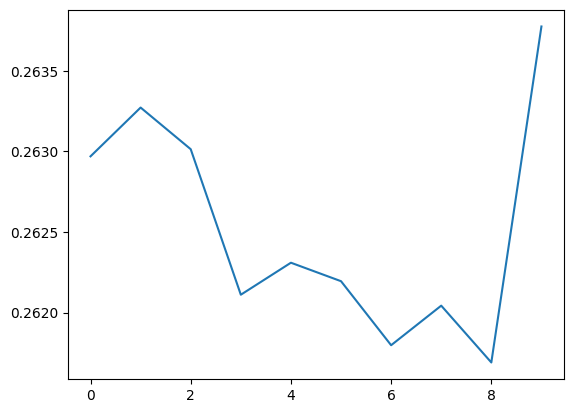

In [ ]:
from IPython.display import Image
plt.plot(training_result["losses"])
plt.show()

# Visualize the Vector Space!

## Generate 64d Representations of the Training Set

In [ ]:
encoded_data = []
labels = []

with torch.no_grad():
    for anchor, _, _, label in tqdm(trainLoader):
        output = model(anchor.to(device))
        encoded_data.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

encoded_data = np.array(encoded_data)
labels = np.array(labels)

100%|██████████| 1265/1265 [00:23<00:00, 53.28it/s]


## Reduce Dimensionality of Data: 64d -> 3d

In [ ]:
# Apply PCA to reduce dimensionality of data from 64d -> 3d to make it easier to visualize!
pca = PCA(n_components=3)
encoded_data_3d = pca.fit_transform(encoded_data)

## Interactive Scatter Plot in 3d – with PCA

In [58]:
scatter = go.Scatter3d(
    x=encoded_data_3d[:, 0],
    y=encoded_data_3d[:, 1],
    z=encoded_data_3d[:, 2],
    mode='markers',
    marker=dict(size=4, color=labels, colorscale='Viridis', opacity=0.8),
    text=labels,
    hoverinfo='text',
)

# Create layout
layout = go.Layout(
    title="MNIST Dataset - Encoded and PCA Reduced 3D Scatter Plot",
    scene=dict(
        xaxis=dict(title="PC1"),
        yaxis=dict(title="PC2"),
        zaxis=dict(title="PC3"),
    ),
    width=1000,
    height=750,
)

# Create figure and add scatter plot
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
fig.show()

## Scatterplot in 2d - with UMAP

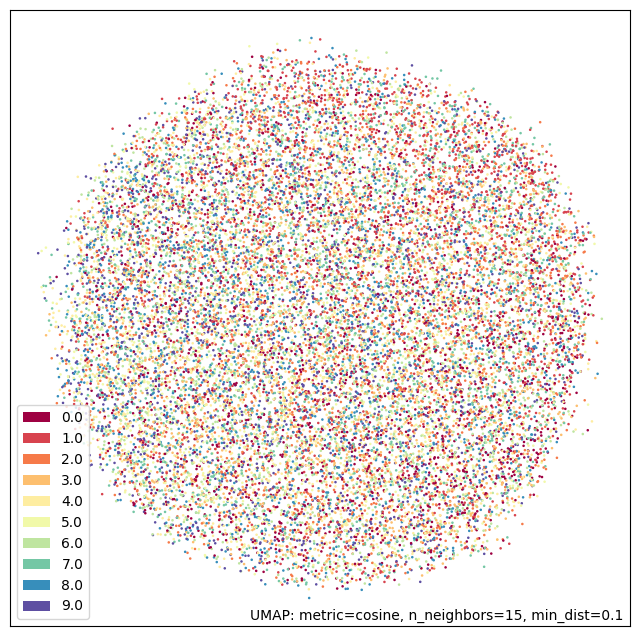

In [57]:
mapper = umap.UMAP(random_state=42, metric='cosine').fit(encoded_data)
umap.plot.points(mapper, labels=labels);

## UMAP with Euclidian Metric

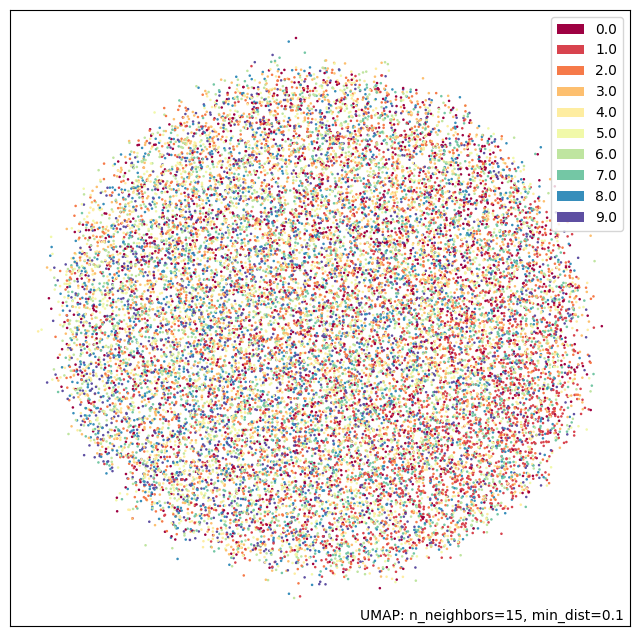

In [59]:
mapper = umap.UMAP(random_state=42).fit(encoded_data)
umap.plot.points(mapper, labels=labels);